# NLP with Disaster Tweets

In [1]:
import numpy as np                                              # Linear Algebra
import pandas as pd                                             # Pandas for DataFrame
from matplotlib import pyplot as plt                            # Matplotlib for plots
import spacy                                                    # Spacy for text processing
import re                                                       # Regex for string extraction
import string                                                   # For using string functions and properties
from sklearn.model_selection import train_test_split            # Used to split the data into training, validation and test sets
from keras.preprocessing.text import Tokenizer                  # Simplifies different tokenizing methods
from keras.utils.vis_utils import plot_model                    # For plotting model

from keras.models import Sequential                             # Sequential model
from keras.layers import Dense                                  # Dense layer

nlp = spacy.load('en_core_web_sm')                  # Load the English language (Options: en_core_web_sm, en_core_web_md, en_core_web_lg)

## Load the data and getting basic idea

In [2]:
path = '/content/drive/MyDrive/Kaggle/NLP-with-Disaster-Tweets/Data'      # For loading from my Drive
# path = 'Data/Raw'   # For loading from local directory

# Load data from path.
train_df = pd.read_csv(f'{path}/Raw/train.csv')
test_df = pd.read_csv(f'{path}/Raw/test.csv')

combine = [train_df, test_df]

# Data head
train_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [3]:
# Data shape
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns for "train_df".')
print(f'There are {test_df.shape[0]} rows and {test_df.shape[1]} columns for "test_df".')

There are 7613 rows and 5 columns for "train_df".
There are 3263 rows and 4 columns for "test_df".


## Exploratory Data Analysis (EDA)
In this step we explore and investigations the following some of the aspects of our datasets. Namely we examine the following ideas:

- Check the usefulness of 'id' column regarding 'target'.
- Preprocessing steps required for the text.
- Possible Feature Extractions of the text.
- Explore 'location' and 'keyword' columns, find their distributions and relations with the 'target'.

### Target feature
About 57.0% are "0" and around 43.0% are "1". Targets are almost equaly distributed. Since there are only two classes, this is a binary classification problem.

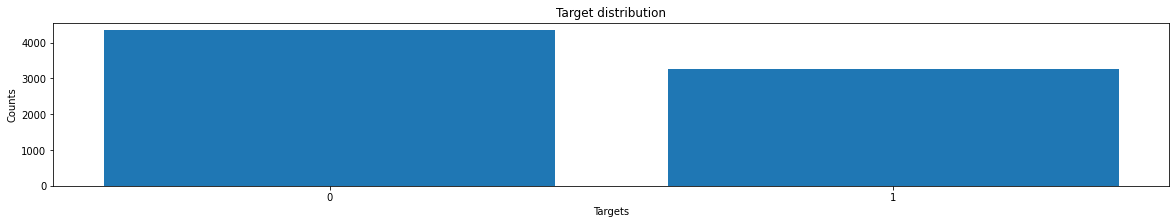

In [4]:
# Check the distribution of tagets
target_counts = train_df['target'].value_counts()

fig = plt.figure(figsize = (20, 3))
plt.title('Target distribution')
plt.xlabel('Targets')
plt.ylabel('Counts')
plt.xticks([0, 1])
plt.bar(target_counts.keys(), target_counts.values)
plt.show()

### Location feature
After careful investigation of the 'location' column, we can take note that:
- Some countries, although the same, have different naming convensions (eg. USA, United states)
- There are some formatting errors (eg. T E X A S)
- 33% of the locations are missing!
- Around 44% of the locations in the dataset are unique. That is a good sign!

- There are 2533 missing entries on "location" column (33.3%)
- Number of unique locations: 3342 (43.9%)


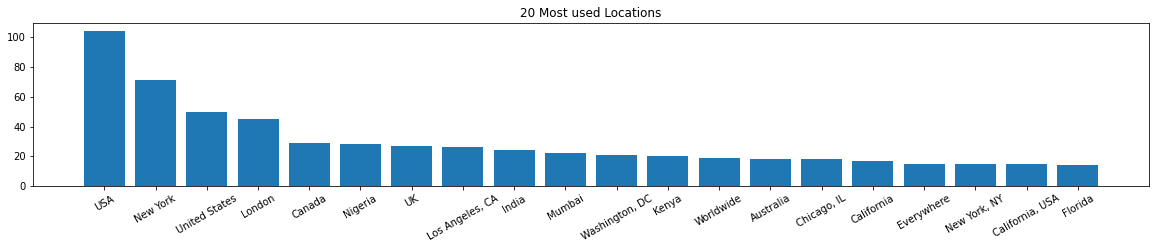

In [5]:
# NULL entries
null_entries = train_df.loc[train_df['location'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "location" column ({round(null_entries_count / train_df.shape[0] * 100, 1)}%)')

# Uniqueness
unique_locations = train_df['location'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique locations: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 20 Top Frequencies
location_freq = train_df['location'].value_counts()
top_20_locs = location_freq[:20]

fig = plt.figure(figsize = (20, 3))
plt.title('20 Most used Locations')
plt.bar(top_20_locs.index, top_20_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Keyword
We understand the followings from a quick analysis of the keywords:
- Most keywords contain space which is represented by '%20'
- Most keywords indicate distaster signs according to our graph. Good sign here!
- Only about 3% of the keywords are unique. This can be a potencially good feature to base the classification on.

- There are 61 missing entries on "keyword" column (0.8%)
Number of unique keyword: 222 (2.92%)


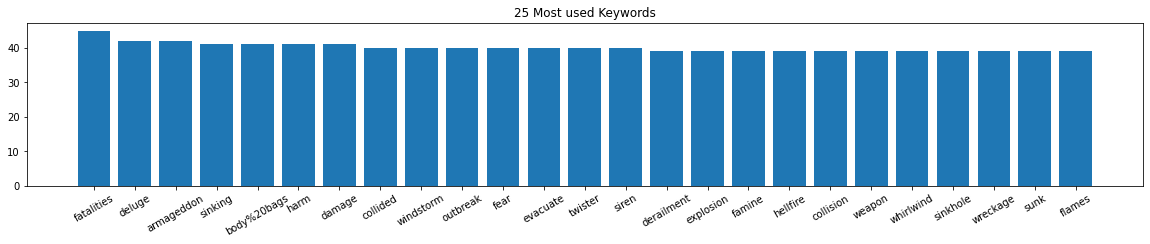

In [6]:
# NULL entries
null_entries = train_df.loc[train_df['keyword'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "keyword" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

# Uniqueness
unique_locations = train_df['keyword'].unique()
unique_locations_count = len(unique_locations)
print(f'Number of unique keyword: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 2t Top Frequencies
keyword_freq = train_df['keyword'].value_counts()
keys_25_locs = keyword_freq[:25]

fig = plt.figure(figsize = (20, 3))
plt.title('25 Most used Keywords')
plt.bar(keys_25_locs.index, keys_25_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Text feature
For the sake of educational purposes, I am going to extract as much information as I can from the text, this includes extracting links, hashtags and mentions and
anything that can be considered useful. Some of the task we are going to be doing:
- There are lot's of #hashtags used that can be helpful, so extract the hashtags and store them in a list for each tweet.
- There also are some links, however, since links are shortened (encoded), they are useless in their basic form. We could scrape each link for headlines and titles, but I'm going to remove them for sipmplicity.
- @mentions can be seen in some tweets, maybe they point to a certain user or something, extract the username and store it in a list for each tweet for later analysis.
- There are some emojies and None-ASCII characters that are better be removed.
- Numbers can also be removed as they may be a little misleading.
- Some comments are fully written in uppercase, we may want to make them lowercase; Or there are words that don't have to be in upper form, like ALLAH.
- There are comments that are almost identical except their links, we can easily detect and remove the duplicates after extracting links (See text[110:120])
- Maybe finding the common words can be useful for identifing which class does each tweet belong to.

#### Feature Extraction
We extract linkes, hashtags and mentions from the tweet texts and store them  in the dataset as lists. By a more careful analysis, it can be shown that links have been shortened. You could scrape each link and search for topics and healines but since there aren't many links in the dataset and that this can be quite time consuming, I decided to use a more simple approach and remove all links.

I also found @mentions useless as they are usernames and usernames can be pretty meaningless and made of random characters. Let's not over-complicate the analysis and remove them as well.

But #hashtags are still very useful as they are used to tag topics and can be used to group tweets.

In [7]:
def extract_hashtag(text):
    matches = re.findall(r'#\w*', text)
    return [match[1:].lower() for match in matches] if matches != [] else None

def extract_mention(text):
    matches = re.findall(r'@\w*', text)
    return [match[1:].lower() for match in matches] if matches != [] else None

def extract_links(text):
    matches = re.findall(r'\bhttps?://\S+', text)
    return matches if matches != [] else None

In [8]:
# Create two new features for #hashtags, @mentions and links
for df in combine:
  df['hashtags'] = df['text'].apply(extract_hashtag)
  df['mentions'] = df['text'].apply(extract_mention)
  df['links'] = df['text'].apply(extract_links)

#### Data Cleaning
This is a quite important step. After randomly looking at out text data, I found it usefull to do the followings:
- Remove all links
- Remove all @mentions
- Remove all non-ASCII characters
- Lemmatize all words (This is a very important step, since lemmatization is a way to reduce the number of words in the text)
- Remove all stop words (Most stop words don't provided much information)
- Remove all punctuations (Careful with this one, since it might remove important information that can be used in Embeddings later on...)
- Conver all words to lower case (Danagerous for Embeddings! - "MIT" is a university in US, but "mit" means "with" in germany)
- Fix text case (Some comments are fully uppercase, it's a good practice to convert them into lowercase. Also there are words that don't have to be uppercase like "ALLAH", which is a proper noun)

In [9]:
# Remove URLs
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# Remove HTML
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

# Converts text to lowercase
def to_lower(text):
  return text.lower()

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Remove mentions
def remove_mentions(text):
    return re.sub(r'@\w*', '', text)

# Remove emojis
def remove_emojis(text):
  regrex_pattern = re.compile(pattern = "["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'',text)

# Remove non-ASCII characters
def remove_non_ascii(text):
    return ''.join(filter(lambda x: x in string.printable, text))

# Lemmatize text
def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

# Remove stopwords
def remove_stopwords(text):
    return ' '.join([token.text for token in nlp(text) if not token.is_stop])

# Remove punctuation
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove white space (Extra step, just in case)
def remove_whitespace(text):
    return ' '.join(text.split())

def clean_text(text, lower = True,html = True,urls = True, numbers = True, mentions = True, ascii = True,
               punctuations = True, stopwords = True, lemmatize = True):
    ''' Properties to remove when cleaning the given text'''    

    # Clean text
    if lower:
      text = to_lower(text)
    if html:
      text = remove_html(text)
    if urls:
      text = remove_urls(text)
    if numbers:
      text = remove_numbers(text)
    if mentions:
      text = remove_mentions(text)
    if ascii:
      text = remove_non_ascii(text)
    if punctuations:
      text = remove_punctuation(text)
    if stopwords:
      text = remove_stopwords(text)
    if lemmatize:
      text = lemmatize_text(text)

    return remove_whitespace(text)      # Last step just in case

In [ ]:
for df in combine:
  df['cleaned_text'] = df['text'].apply(clean_text)

train_df.head()

Let's do more EDA on our features now that we've done some feature extraction. It can be shown from the below plot that our new features like #hashtags and @mentions are not very useful. We'll be removing them from our features. We will also remove links as they are not very useful as discussed earlier.

In [ ]:
feature_counts = train_df.count()

fig = plt.figure(figsize = (20, 3))
plt.title('Features counts')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.bar(feature_counts.keys(), feature_counts.values)
plt.show()

That brings us to our first place, with no new features to work with. But that's ok because that was necessary to get us to the point where we can be confident in our decisions about removing them from our text data.

In [ ]:
train_df.to_csv(f'{path}/Processed/train.csv', index = False)
test_df.to_csv(f'{path}/Processed/test.csv', index = False)

## Deep Leaning Models

In [ ]:
train_df = pd.read_csv(f'{path}/Processed/train.csv')
test_df = pd.read_csv(f'{path}/Processed/test.csv')

combine = [train_df, test_df]

for df in combine:
  df.dropna(axis = 0, subset = ['cleaned_text'], inplace = True)
  df.dropna(axis = 0, subset = ['cleaned_text'], inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1).reset_index(drop = True)

train_df.info()

### Encoding

In [ ]:
tokenizer = Tokenizer(lower = True, oov_token = '?')
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Modes: 'binary', 'count', 'freq', 'tfidf'
train_encodes = tokenizer.texts_to_matrix(train_df['cleaned_text'], mode = 'count')
test_encodes = tokenizer.texts_to_matrix(test_df['cleaned_text'], mode = 'count')

print('Matrix shape:', train_encodes.shape)

### Building the model

In [ ]:
def build_model(x, loss, optimizer, metrics):
  model = Sequential()
  model.add(Dense(units = 64, input_shape = (x.shape[1],), activation = 'relu'))
  model.add(Dense(units = 1, activation = 'sigmoid'))
  model.compile(loss = loss, optimizer = optimizer, metrics = metrics)  

  return model

In [ ]:
def train_model(model, x, y, epochs, batch_size, validation_split):
  history = model.fit(
    x = x,
    y = y,
    epochs = epochs,
    batch_size = batch_size,
    
    validation_split = validation_split
  )

  return history.history

In [ ]:
def plot_model_training(epochs, history, metrics):    

  def plot_subplot(axs, metric, val_metric):
    ''' Plot a single subplot '''

    axs.set_title('Analysis of ' + metric)
    axs.plot(epochs, history[metric], label = metric)
    axs.plot(epochs, history[val_metric], label = val_metric)
    axs.legend()

  fig, axs = plt.subplots(1, len(metrics), figsize = (18, 5))

  for i, metric in enumerate(metrics):
    plot_subplot(axs[i], metric, 'val_' + metric)

### Build, train, plot

In [ ]:
X_train = train_encodes
y_train = train_df['target']

# Build model
model = build_model(
  x = X_train,
  loss = 'binary_crossentropy',
  optimizer = 'adam',
  metrics = ['accuracy']
)

# Plot model
plot_model(model = model, show_dtype = True, show_shapes = True, show_layer_names = False)

# Train model
history = train_model(
  model = model,
  x = X_train,
  y = y_train,
  epochs = 10,
  batch_size = 64,
  validation_split = 0.2
)

# Plot training process
epochs = [i for i in range(len(history['loss']))]
plot_model_training(
  epochs = epochs,
  history = history,
  metrics = ['accuracy', 'loss']
)

### Make prediction

In [ ]:
X_test = test_encodes

pred = model.predict(X_test, verbose = 2)
pred = np.round(pred).astype(int).reshape(pred.shape[0])

# Create submission
sub=pd.DataFrame({'id': test_df['id'].values.tolist(), 'target': y_pre})
sub.to_csv(path + 'submission.csv', index = False)